# Conditional Generative Adversarial Network


# Import thư viện

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms


# Input dữ liệu

In [2]:
# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 100
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# convert data to torch.FloatTensor
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    )

# get the training Fashion MNIST datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform,)
# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Visualize dữ liệu

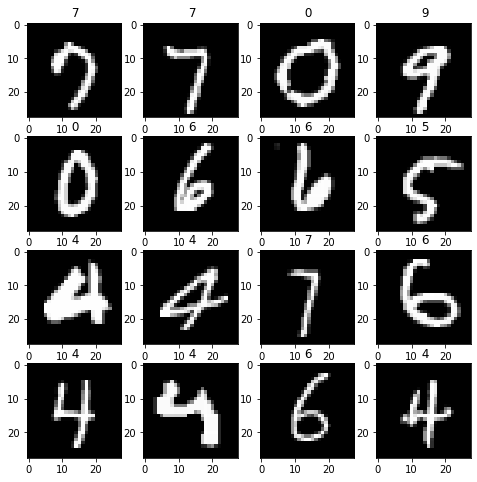

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()



# Trực quan hoá dữ liệu
def draw_samples(imgs,labels):
  plt.subplots(4, 4, figsize=(8,8))
  # số lượng sample trên hàng và cột
  columns = 4
  rows = 4
  for i in range(1, columns*rows+1):
      img = np.squeeze(imgs[i-1])
      plt.subplot(rows, columns, i)
      plt.title((f' {labels[i-1]}'))

      plt.imshow(img,  cmap='gray')
  plt.show()  


draw_samples(images,labels)




---
# Xây dựng mô hình

## Discriminator

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        input_size = input_size + 10
        self.label_embedding = nn.Embedding(10, 10)

        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_dim*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.fc4 = nn.Sequential(
            nn.Linear(hidden_dim, output_size),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x, c], 1)
        output = self.fc1(x)
        output = self.fc2(output)
        output = self.fc3(output)
        out = self.fc4(output)

        return out.to(device)

## Generator

In [5]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        input_size = input_size + 10
        self.label_embedding = nn.Embedding(10, 10)
        
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.LeakyReLU(0.2)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(0.2)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.LeakyReLU(0.2)
        )

        self.fc4 = nn.Sequential(
            nn.Linear(hidden_dim*4, output_size),
            nn.Tanh()
        )
    
    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x,c], 1)
        output = self.fc1(x)
        output = self.fc2(output)
        output = self.fc3(output)
        output = self.fc4(output)
        return output.to(device)

## Siêu tham số của mô hình

In [6]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 128


# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 128

## Xây dựng mạng hoàn chỉnh


In [7]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)

G = Generator(z_size, g_hidden_size, g_output_size)
D.to(device)
G.to(device)
# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (label_embedding): Embedding(10, 10)
  (fc1): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc4): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

Generator(
  (label_embedding): Embedding(10, 10)
  (fc1): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (fc2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (fc3): Sequential(
    (0): Linear(in_fe

---
## Discriminator and Generator Losses ( Xây dựng hàm mất mát cho D và G )
## Optimizers 

Sử dụng hàm tối ưu hoá Adam cho cả 2 mạng

In [8]:
import torch.optim as optim

# Optimizers
lr = 0.0002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)



loss = nn.BCELoss()

---
# Training ( Huấn luyên)


In [9]:
import pickle as pkl
# training hyperparams
num_epochs = 20

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 800

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
# sample_size=16
fixed_z = torch.randn(batch_size,100)
# fixed_z = torch.from_numpy(fixed_z).float()
fixed_label = torch.randint(0, 10, (batch_size,)).to(device)
# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    for batch_i, data in enumerate(train_loader):
        real_images = data[0]
        lables = data[1]
        if real_images.size(0)!=100: 
            print(real_images.size(0))

        z = torch.randn(batch_size,100).to(device)
        fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
        fake_images = G(z,fake_labels)
        

        
        true_loss = torch.ones(batch_size).to(device)
        fake_loss = torch.zeros(batch_size).to(device)
        ## Important rescaling step ## 
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        real_imgs = real_images.view(batch_size, 784)
        
        
        d_optimizer.zero_grad()

        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        
        D_real = D(real_imgs,labels).view(batch_size)
        d_real_loss = loss(D_real,true_loss)

        
        
        # 2. Train with fake images

        # Generate fake images
        # gradients don't have to flow during this step


        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images.detach(),fake_labels).view(batch_size)
        d_fake_loss = loss(D_fake,fake_loss)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()


      # =========================================
      #            TRAIN THE GENERATOR
      # =========================================
        g_optimizer.zero_grad()

      # 1. Train with fake images and flipped labels

      # Generate fake images
        fake_images = G(z,fake_labels)

      # Compute the discriminator losses on fake images 
      # using flipped labels!
        D_fake = D(fake_images,fake_labels).view(batch_size)
        g_loss = loss(D_fake,true_loss) # use real loss to flip labels

        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
#             if epoch % 4 ==0:
          # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                epoch+1, num_epochs, d_loss.item(), g_loss.item()))
       
            


    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))

    # generate and save sample, fake images
    # G.eval() # eval mode for generating samples
    samples_z = G(fixed_z,fixed_label)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   20] | d_loss: 1.3764 | g_loss: 0.6659
Epoch [    2/   20] | d_loss: 1.0488 | g_loss: 1.8198
Epoch [    3/   20] | d_loss: 0.6536 | g_loss: 3.5932
Epoch [    4/   20] | d_loss: 0.3808 | g_loss: 3.6777
Epoch [    5/   20] | d_loss: 0.2697 | g_loss: 4.0724
Epoch [    6/   20] | d_loss: 0.2350 | g_loss: 3.6240
Epoch [    7/   20] | d_loss: 0.2458 | g_loss: 3.4823
Epoch [    8/   20] | d_loss: 0.5033 | g_loss: 2.7587
Epoch [    9/   20] | d_loss: 0.6810 | g_loss: 1.8671
Epoch [   10/   20] | d_loss: 0.3320 | g_loss: 2.7010
Epoch [   11/   20] | d_loss: 0.5018 | g_loss: 2.3976
Epoch [   12/   20] | d_loss: 0.9077 | g_loss: 2.1720
Epoch [   13/   20] | d_loss: 0.6483 | g_loss: 2.5086
Epoch [   14/   20] | d_loss: 0.5897 | g_loss: 2.4027
Epoch [   15/   20] | d_loss: 0.8196 | g_loss: 1.9589
Epoch [   16/   20] | d_loss: 0.8146 | g_loss: 1.9355
Epoch [   17/   20] | d_loss: 0.5460 | g_loss: 2.3790
Epoch [   18/   20] | d_loss: 0.7190 | g_loss: 2.2081
Epoch [   19/   20] | d_loss

## Training loss
Biểu đồ training losses cho G và D, lưu lại sau mỗi epoch train.

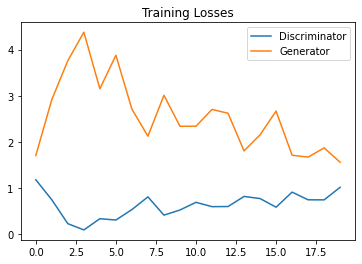

In [10]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training (Tạo samples từ quá trình huấn luyện)


Xem 1 số hình ảnh từ bộ sinh generator trong quá trình đào tạo

In [11]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

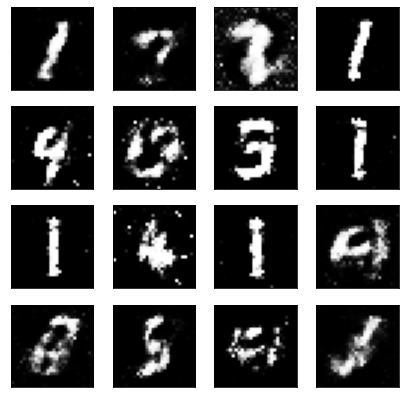

In [12]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    # -1 indicates final epoch's samples (the last in the list)


view_samples(-1, samples)

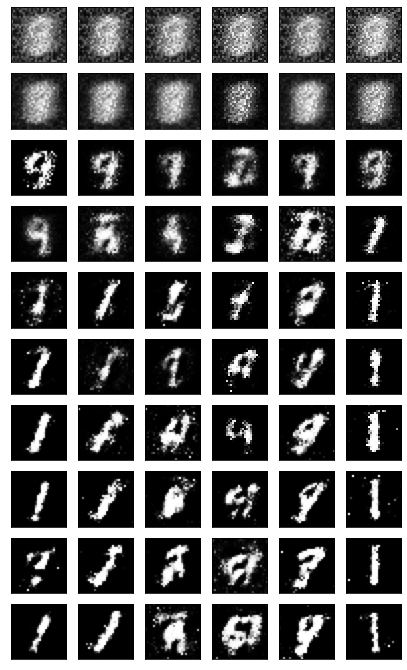

In [13]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Sampling from the generator



0


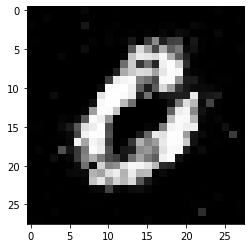

In [16]:
# randomly generated, new latent vectors
rand_z = torch.randn(batch_size,100).to(device)
rand_labels = torch.randint(0, 10, (batch_size,)).to(device)
G.eval() # eval mode
# generated samples
rand_images = G(rand_z,rand_labels).view(batch_size, 28, 28)

for x in rand_images:
#     for i in range(0,10):
    print(rand_labels[0].item())
    plt.imshow(x.detach().numpy(), interpolation='nearest',cmap='gray')
    plt.show()

    break

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
# view_samples(0, [rand_images])